# Example of downsampling and interpolating data with `romSpline`

In [1]:
# Import necessary modules
import numpy as np, matplotlib.pyplot as plt
%matplotlib inline

# Set plot font and size
font = {'family':'Times New Roman', 'size':14}
plt.rc('font', **font)

# Uncomment next two lines if romSpline is not in your PYTHONPATH
# import sys
# sys.path.append(<path to your copy of romspline>)

import romspline

Make up some test data to show how to use the code.

Incidentally, this function is accesible with romSpline through 
the `TestData` class. There are options to add Gaussian
noise and/or high frequency oscillations to this otherwise 
smooth function. See the documentation for further details.

In [2]:
x = np.linspace(-1, 1, 100001)

def f(x):
    return 100.*( (1.+x)*np.sin(5.*(x-0.2)**2) + np.exp(-(x-0.5)**2/2./0.01)*np.sin(100*x) )

Plot the test data to see how it looks.

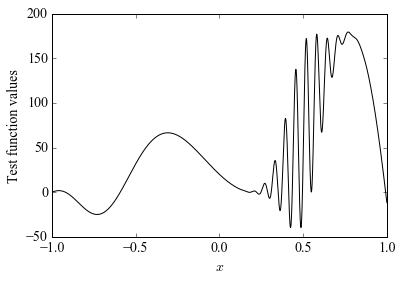

In [3]:
plt.plot(x, f(x), 'k-');
plt.xlabel('$x$');
plt.ylabel('Test function values');

## Building a reduced-order spline

Create a reduced-order spline by making an instance of the `ReducedOrderSpline` class.

In [8]:
spline = romspline.ReducedOrderSpline(x, f(x), verbose=True)

# Additional options include:
#     deg -- degree of interpolating spline polynomials (default is 5)
#     tol -- tolerance of greedy algorithm (default is 1e-6)
#     rel -- use relative errors if True (default is False)


Size 	Error
7 	109.923909402
8 	200.735648108
9 	2378.48939455
10 	1084.67620686
11 	722.724632227
12 	491.921200922
13 	658.498153554
14 	345.494055596
15 	289.79994798
16 	400.056305789
17 	480.881557483
18 	473.89818132
19 	339.760656984
20 	312.348775991
21 	298.402466704
22 	293.191345999
23 	221.48957756
24 	214.196073872
25 	272.707510515
26 	207.458156046
27 	160.726679878
28 	139.574873685
29 	66.6195064279
30 	51.95872435
31 	40.2956373144
32 	30.4583285679
33 	26.2806404373
34 	23.7367034642
35 	18.8089851872
36 	17.7907446738
37 	13.506634482
38 	11.6732677074
39 	6.88675206695
40 	6.86892121717
41 	5.09704029615
42 	4.89234654309
43 	3.26935478145
44 	3.11819667034
45 	2.63016942199
46 	2.54223206129
47 	2.53868769459
48 	2.52612135534
49 	1.99661662702
50 	1.98323345886
51 	1.42355380649
52 	0.921708051205
53 	0.896236023613
54 	0.588439577505
55 	0.44610967306
56 	0.413508450138
57 	0.880269498547
58 	0.559703265237
59 	0.454164087744
60 	0.384660270789
61 	0.3258219486

Because data, namely, $x$ and $f(x)$, are given then the class goes ahead and builds the
reduced-order spline via a greedy algorithm. The number of optimal points and the 
resulting compression factor are:

In [10]:
print "Number of optimal points:", spline.size
print "Compression factor:", spline.compression

Number of optimal points: 447
Compression factor: 223.715883669


Plot the max L-infinity errors that were found in building the "optimal" spline.
These errors are sometimes called "greedy errors" since they are computed
in a greedy algorithm. Notice that the decay is polynomial (power is deg+1) 
and not exponential. This is because the spline is only smooth to the degree of 
the polynomial used. For this reason, it's good not to set the tolerance too high 
(e.g., numerical round-off) as the time to generate spline might be impractically 
long.

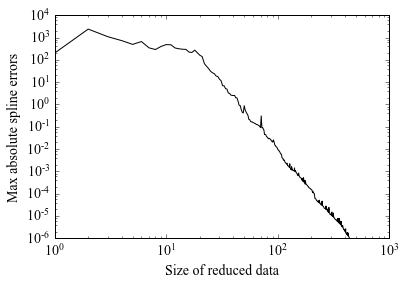

In [6]:
plt.loglog(spline.errors, 'k-');
plt.ylabel('Max absolute spline errors');
plt.xlabel('Size of reduced data');

The distribution of the "optimal" points (called $X$ in the code) 
is not uniform. Generally speaking, the density of the points is 
highest around the data that exhibits more variations.

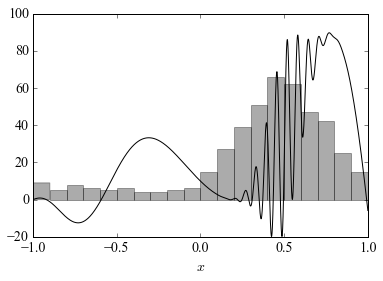

In [12]:
plt.hist(spline.X, 20, color='k', alpha=0.33)
plt.plot(x, f(x)/2., 'k-')
plt.xlabel('$x$');

## Evaluating a reduced-order spline

To evaluate the reduced-order spline let's first create an array of new randomly selected samples from the same interval as the `x` array:

In [13]:
import random
xx = np.sort([random.uniform(x.min(), x.max()) for ii in range(10000)])

Then use the `eval` method to evaluate the spline.

In [14]:
y1 = spline.eval(xx)

You could also just call `spline` directly as follows:

In [15]:
y2 = spline(xx)

Both ways of evaluating the spline are equivalent, namely, their difference is an array of zeros

In [16]:
np.all(np.abs(y1-y2) == 0.)

True

## Exporting/importing reduced-order spline data to/from file

`romSpline` provides functions to write the relevant spline interapolant data to HDF5 and text formats by calling the `write method`. The `write` method is fairly flexible as you can enter a filename, an HDF5 file descriptor, or an HDF5 group descriptor (if you have multiple reduced-order spline interpolants to export). 

In [17]:
# Write data to HDF5 file given a filename
spline.write("test1.h5")

# Write data to HDF5 file by passing a file descriptor
import h5py
fp = h5py.File('test1a.h5', 'w')  # This is the file descriptor (fp)
spline.write(fp)
fp.close()

# Write data to HDF5 file by passing a group descriptor
fp = h5py.File('test1b.h5', 'w')
group = fp.create_group('this_is_a_group')  # This is a group descriptor called "group"
spline.write(group)
fp.close()

The interpolant data can also be written in a text format by simply passing a filename with ".txt" extension. The `write` method creates a directory with the given filename and creates a separate text file for each piece of interpolant data.

In [18]:
spline.write('test1.txt')

The `write` method has a keyword option called "slim" (default is False) that writes only the reduced data as well as the polynomial degree (`deg`) and greedy tolerance (`tol`). This is the minimum data needed to reconstruct the reduced-order spline interpolant. In particular, the array of greedy errors is not written to file when `slim` is True.

Next, let's pretend you've already saved the reduced-order spline data to file and want to reconstruct and evalute the interpolant. Fortunately, one doesn't need to rerun the greedy algorithm. Instead, use the `read` method of the `ReducedorderSpline` class.

In [19]:
s = romspline.ReducedOrderSpline()  # Don't initialize with anything
print "Is spline made/available?", s._made  # Reduced-order spline is not made/available

s.read('test1.h5')  # Load interpolant data
print "Is spline made/available?", s._made  # Reduced-order spline is made/available

Is spline made/available? False
Is spline made/available? True


You can check that data was actually loaded by simply evaluating the spline at the samples `xx`.

In [20]:
s(xx)

array([  0.02507817,   0.02562137,   0.02626165, ..., -11.34586772,
       -11.6036538 , -11.61724172])

One doesn't need to create a ReducedOrderSpline object to import the data of a previously generated reduced-order spline if one uses the `readSpline` function. This function can read both HDF5 and text file formats provided that the files were created with romSpline's `write` function discussed above. Recall that this function creates a directory of text files when requesting text format.

In [21]:
# Read from HDF5 file
s_h5 = romspline.readSpline('test1.h5')
print s_h5(xx)

# Read from text file(s)
s_txt = romspline.readSpline('test1.txt')
print s_txt(xx)

[  0.02507817   0.02562137   0.02626165 ..., -11.34586772 -11.6036538
 -11.61724172]
[  0.02507817   0.02562137   0.02626165 ..., -11.34586772 -11.6036538
 -11.61724172]


## Some other basic features and functions

The `ReducedOrderSpline` class comes with a function called `test` that simply compares the interpolated values of the reduced-order spline to some set of "truth" data, which in this example are the function values themselves. Below is shown the absolute difference between these two sets of values. Also plotted in blue is the tolerance of the greedy algorithm ($10^{-6}$ here).

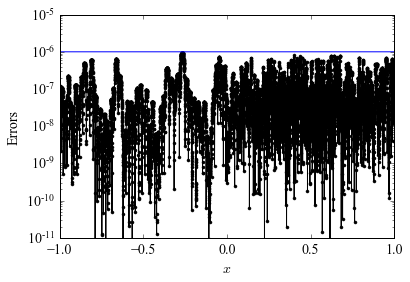

In [22]:
plt.semilogy(xx, spline.test(xx, f(xx)), 'k.-');
plt.semilogy(xx, spline.tol*np.ones_like(xx), 'b-');
plt.ylim(1e-11, 1e-5);
plt.xlabel('$x$');
plt.ylabel('Errors');

We can rerun the greedy algorithm to make a reduced-order spline with a difference tolerance, for example. Using the same object `spline` (or you can create a new one), we run the greedy method:

In [23]:
spline.greedy(x, f(x), tol=1e-3)

When we made our first reduced-order spline above, we were actually calling the `greedy` method. When the `ReducedOrderSpline` class is initialized with data (i.e., samples and values) then the `greedy` method is executed on that data. If only values are given (i.e., no samples, like $x$) then the `greedy` method is executed but the samples are assumed to be integers from zero to the number of values less one.

And let's plot the interpolation errors at the samples `xx` like we did earlier.

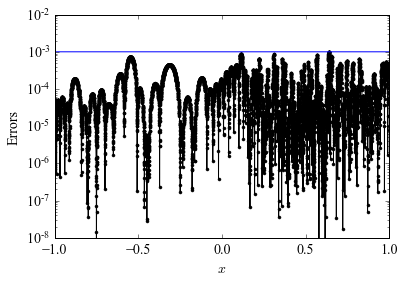

In [24]:
plt.semilogy(xx, spline.test(xx, f(xx)), 'k.-');
plt.semilogy(xx, spline.tol*np.ones_like(xx), 'b-');
plt.ylim(1e-8, 1e-2);
plt.xlabel('$x$');
plt.ylabel('Errors');

You can write this spline data to file, just as before.

In [25]:
spline.write('test2.h5')   # In HDF5 format
spline.write('test2.txt')  # In text format

A reduced-order spline can also be built where the tolerance is defined relative to the maximum of the abolute value of the data. This can be done using the `rel` option. The tolerance that is being input is the desired relative tolerance (i.e., $10^{-3}$ relative to the largest absolute data value).

In [26]:
spline.greedy(x, f(x), tol=1e-3, rel=True)

print "The compression factor is:", spline.compression
print "The (relative) tolerance requested is", spline._tol
print "The (absolute) tolerance used is:", spline.tol, spline._tol * np.max(np.abs(f(x)))

The compression factor is: 1587.31746032
The (relative) tolerance requested is 0.001
The (absolute) tolerance used is: 0.179373340905 0.179373340905


Let's plot the interpolation error on the random samples `xx` to see how they compare to the relative tolerance, which the code translates into an absolute tolerance that depends on the largest absolute data value in the array.

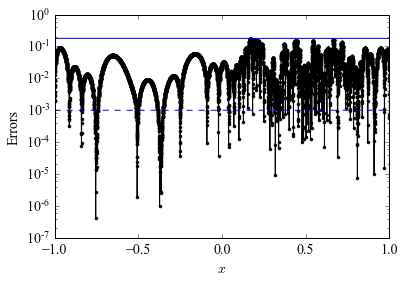

In [27]:
plt.semilogy(xx, spline.test(xx, f(xx)), 'k.-', 
            xx, spline._tol*np.ones(xx.size), 'b--',  # Requested relative tolerance (_tol)
            xx, spline.tol*np.ones(xx.size), 'b-'     # Actual absolute tolerance used (tol)
);
plt.xlabel('$x$');
plt.ylabel('Errors');

## Reduced-order splines and derivatives

The spline interpolation functionality is achieved using `scipy.interpolate`'s class called  `UnivariateSpline`. As a result, we have direct access to derivatives of the spline. The number of derivatives available to us equals to the polynomial degree used to build the spline. Otherwise, `UnivariateSpline` throws an error.

Let's build a spline with absolute tolerance of $10^{-3}$ and using fifth degree polynomials.

In [28]:
spline = romspline.ReducedOrderSpline(x, f(x), tol=1e-3)
print "Size of spline =", spline.size
print "Compression factor =", spline.compression

Size of spline = 151
Compression factor = 662.258278146


The first derivative of the spline on the random samples `xx` is found by evaluating the spline as described (recall, there are two ways to do this) above but entering an integer (for the number of derivatives we want) for the `dx` option:

In [29]:
spline(x, dx=1)

array([   79.34054226,    79.31150202,    79.28244828, ..., -1603.17786564,
       -1603.2364301 , -1603.29495813])

However, we will incur some additional errors because the interpolation approximation is being differentiated, not the function data. To see this more clearly, we can build a reduced-order spline for the first derivative of the function values, which can be calculated analytically:

In [30]:
def dfdx(x):
    """Analytic derivative of f(x) test data"""
    a = 10.*(-0.2+x)*(1.+x)*np.cos(5.*(-0.2 + x)**2)
    b = 100.*np.exp(-50.*(-0.5+x)**2)*np.cos(100.*x)
    c = np.sin(5.*(-0.2+x)**2)
    d = -100.*np.exp(-50.*(-0.5+x)**2)*(-0.5+x)*np.sin(100.*x)
    return 100.*(a+b+c+d)

Now, generate the reduced-order spline for the `dfdx` data and plot the derivative of the spline together with the spline of the derivative.

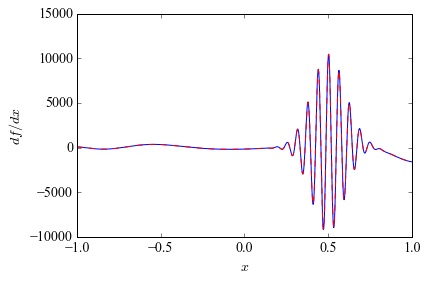

In [26]:
# Reduced-order spline of the analytic derivative:
dspline = romspline.ReducedOrderSpline(x, dfdx(x), tol=1e-3)

plt.plot(xx, spline(xx, dx=1), 'b-');  # Derivative of spline built for f(x)
plt.plot(xx, dspline(xx), 'r--');      # Spline built for derivative of f(x)
plt.xlabel('$x$');
plt.ylabel('$df/dx$');

By the eyeball norm the two interpolation predictions seem to agree but there actually is a difference in this case. The spline computed for the derivative of the data tends to be more accurate than computing the derivative of the spline built for the $f(x)$ data.

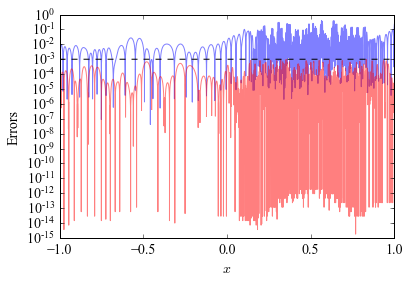

In [27]:
y = f(x)      # Store function values
y1 = dfdx(x)  # Store analytically calculated derivative

# This tests the first derivative of the spline prediction and compares to y1
plt.semilogy(x, spline.test(x, y1, dx=1), 'b-', alpha=0.5);  

# This tests the spline prediction of the first derivative of the data 
# and compares to y1
plt.semilogy(x, dspline.test(x, y1), 'r-', alpha=0.5);

plt.semilogy(x, dspline.tol*np.ones(x.size), 'k--');
plt.ylabel('Errors');
plt.xlabel('$x$');

As you can see above, the red curve is below the tolerance used in the greedy algorithm (i.e., $10^{-3}$). Note that the plot is generated at the samples $x$ used to train the greedy algorithm for building both splines. However, only the spline built from the derivatives of the data are actually guaranteed to have errors below the tolerance.

To summarize, you can compute derivatives with a reduced-order spline (or, any other spline, in fact) but additional errors will be accrued in the process. So, please have this in mind if your application involves derivatives. You can retain accuracy by instead building a reduced-order spline specifically for the derivatives.

If we didn't have access to the analytical derivative of the data then we can use finite-difference differentiation to numerically compute the derivative and build a spline for that data. This is achieved using the `D` function in `romSpline`.

In [28]:
# Compute numerical derivative of data
Df = romspline.D(f(x), x)  # Default options: dx=1, order=4

# Build a reduced-order spline for the numerical derivative
Dspline = romspline.ReducedOrderSpline(x, Df, tol=1e-3)
print "Size of spline =", Dspline.size
print "Compression factor =", Dspline.compression

# Notice that more points are needed for the derivative. This happens
# because we are imposing a tol on the *absolute* error of 1e-3 here
# and the derivative is large for some values of x.

Size of spline = 355
Compression factor = 281.692957746


Notice that the reduced data size is larger for building a reduced-order spline for the derivative of the data. This happens, in part, because we are imposing an absolute tolerance of $10^{-3}$ here and the derivative can be large at some samples.

As in the case with the analytical derivatives studied above, the spline built from the numerical derivative (`Dspline`) is more accurate than evaluating the derivative of the spline built from the original data (`spline`).

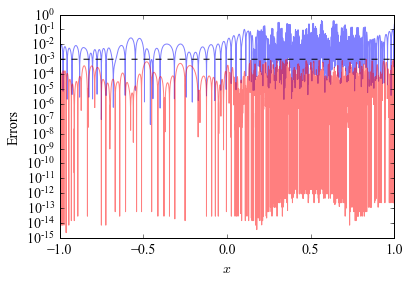

In [29]:
plt.semilogy(x, spline.test(x, y1, dx=1), 'b-', alpha=0.5);
plt.semilogy(x, Dspline.test(x, Df), 'r-', alpha=0.5);
plt.semilogy(x, Dspline.tol*np.ones(x.size), 'k--');
plt.xlabel('$x$');
plt.ylabel('Errors');